## Interactive Tkinter dialog to plot spectra

*Last update: June 2021*

This tutorial shows how to create a basic interactive dialog to select files to read and plot XAS spectra.
For this we will be using the [Tkinter](https://docs.python.org/3/library/tkinter.html) (Tk interactive) library of Python.

The following steps are covered in this notebook:

1. Creating a TKinter dialog to ask for filenames.
2. Reading the files and plotting the contents through a specified backend.
3. Wrapping both routines in a single Tk widget application.

This tutorial assumes that the files that you want to visualize are available in your local machine.
If no such files are available, you can download and uncompress the following example files:
[p65_example_files.zip](p65_example_files.zip)

In [1]:
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version      : 3.9.4
Numpy version       : 1.20.3
Scipy version       : 1.6.3
Lmfit version       : 1.0.2
H5py version        : 3.2.1
Matplotlib version  : 3.4.2
Araucaria version   : 0.1.10


### Creating a Tkinter dialog to ask for filepaths

As a first step we will create a dialog to request the filepaths for the files we want to visualize. We will use the [Tk](https://docs.python.org/3/library/tkinter.html#tkinter.Tk) class to create a top-level widget, and the [askopenfilenames()](https://docs.python.org/3/library/dialog.html#tkinter.filedialog.askopenfiles) function to deploy the open dialog window.

Note that we assign the retrieved files paths to the `fpaths` variable, and then destroy the top-level widget.
Lets run the code and inspect the results!

In [2]:
from tkinter import Tk, filedialog
root   = Tk()
fpaths = filedialog.askopenfilenames(initialdir = "/",title = "Select scan file")
root.destroy()

# printing filepahts
for fpath in fpaths:
    print(fpath)

.../20K_GOE_Fe_K_240.00000.xdi


<div class="alert alert-info">
    
    **Note**
    
    Your filepaths will vary according to the location of files in your local machine.
    
    If you want to access different files, just navigate and select them in the interactive Tk dialog.
    
</div>

### Reading files and plotting XAFS spectra

Once the filepaths have been retrieved, we can use the functions available in the [io_read](../../io/io_read.rst) module of `araucaria`. Here we will use the [read_p65()](../../io/io_read.rst#araucaria.io.io_read.read_p65) function, since the spectra was aquired at the P65 beamline (PETRA III - DESY).

<div class="alert alert-info">
    
    **Pro tip**
    
    You can modify the code to read a file from another source. For this you can check the functions available at the 
    [io_read](../../io/io_read.rst) module.
</div>

Some notes about the code:

- For convenience we create a template figure with the [fig_xas_template()](../../plot_module.rst#araucaria.plot.template.fig_xas_template) function of `araucaria`.
- Instead of using the [pyplot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) interface of `matplotlib` to render the plot, we explicitly request the [FigureCanvasTkAgg](https://matplotlib.org/stable/api/backend_tk_api.html#matplotlib.backends.backend_tkagg.FigureCanvasTkAgg) backend class to create a canvas.
- The canvas gets draw upon being instantiated, while the custom plot() function updates the axes by redrawing the artists.

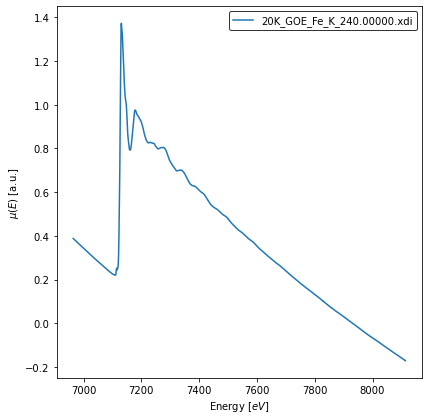

In [3]:
from os.path import basename
from araucaria.io import read_p65
from araucaria.plot import fig_xas_template
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# creating figure and axes instances
figkws  = {'figsize': (6,6)}
fig, ax = fig_xas_template(panels='x', **figkws)
ax.set_ylabel('$\mu(E)$ [a.u.]')

# creating canvas
canvas = FigureCanvasTkAgg(fig)
canvas.draw()

def plot(fpaths):
    """Plots XAFS spectra from filepaths.
    """
    # removing previous artists
    for artist in ax.get_lines():
        artist.remove()

    # plotting new artists
    mode    = 'mu'   # transmision mode
    offset  = 0.1    # offset for visualization
    for i, fpath in enumerate(fpaths):
        group = read_p65(fpath, scan=mode)
        ax.plot(group.energy, group.mu + i*offset, label=basename(fpath))
    ax.legend(edgecolor='k')

    # redrawing the figure
    canvas.draw()
    
# calling the plotting function
plot(fpaths)

# deleting canvas
del(canvas)

### Wrapping routines in a single Tk widget application

We now combine the previous steps to produce a single Tk widget application. Once again we use a [Tk](https://docs.python.org/3/library/tkinter.html#tkinter.Tk) instance for the toplevel widget, but we will attach it to an application that continously listens for user events:

- We define a custom Application class with methods to create 3 widgets: (i) a plot button, (ii) a quit button, and (iii) the figure canvas. Note that upon instantiation the figure canvas gets created and displayed.
- The Tk canvas is embedded in the widget using the [FigureCanvasTkAgg](https://matplotlib.org/stable/api/backend_tk_api.html#matplotlib.backends.backend_tkagg.FigureCanvasTkAgg) backend canvas. We also provide an interactive navigation toolbar with the [NavigationToolbar2](https://matplotlib.org/stable/api/backend_bases_api.html#matplotlib.backend_bases.NavigationToolbar2) class.
- The [Button](https://tkdocs.com/shipman/button.html) widget is used for the buttons. In particular, the plot button displays the open dialog window and updates the plot with the selected files.

Lets run this code to plot spectra through a widget application!

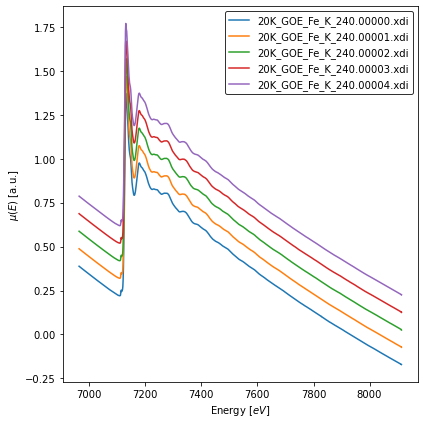

In [4]:
from os.path import basename
from tkinter import Frame, Tk, Button, filedialog
from araucaria.io import read_p65
from araucaria.plot import fig_xas_template
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

class Application(Frame):
    def __init__(self, master=None):
        super().__init__(master)
        master.geometry('600x600')
        master.title('Tk interactive plot')
        self.master = master
        self.pack()
        self.create_widgets()

    def create_widgets(self):
        # plot button
        self.plot_button            = Button(self)
        self.plot_button["text"]    = "Select files and plot"
        self.plot_button["command"] = self.plot
        self.plot_button.pack()

        # quit button
        self.quit = Button(self, text="Quit",
                           command=self.master.destroy)
        self.quit.pack()

        # figure canvas
        figkws            = {'figsize': (6,6)}
        self.fig, self.ax = fig_xas_template(panels='x', **figkws)
        self.ax.set_ylabel('$\mu(E)$ [a.u.]')
        self.canvas       = FigureCanvasTkAgg(self.fig, master = self.master)
        self.canvas.draw()

        # placing the canvas on the Tkinter window
        self.canvas.get_tk_widget().pack()

        # creating the Matplotlib toolbar
        self.toolbar = NavigationToolbar2Tk(self.canvas, self.master)
        self.toolbar.update()

        # placing the toolbar on the Tkinter window
        self.canvas.get_tk_widget().pack()

    def plot(self):
        self.fpaths =  filedialog.askopenfilenames(initialdir = "/",
                                                 title = "Select scan file")
        
        # removing previous artists and resetting prop cycle
        for artist in self.ax.get_lines():
            artist.remove()
        self.ax.set_prop_cycle(None)

        # plotting new artists
        mode    = 'mu'
        offset  = 0.1
        for i, fpath in enumerate(self.fpaths):
            group = read_p65(fpath, scan=mode)
            self.ax.plot(group.energy, group.mu + i*offset, label=basename(fpath))
        self.ax.legend(edgecolor='k')
        self.fig.tight_layout()

        # redrawing the figure
        self.fig.canvas.draw()

root = Tk()
app = Application(master=root)
app.mainloop()